In [4]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline
from diffusers import utils
from diffusers import UNet2DConditionModel
from diffusers import AudioLDMPipeline
from diffusers import DDIMScheduler,PNDMScheduler

from torchvision.utils import save_image
import csv
import IPython.display as ipd

import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import argparse, os, sys, datetime, glob, importlib, csv
import math

sys.path.append(os.getcwd())
# import cv2
import torchaudio
import torchaudio.transforms as transforms
import time
from encodec import EncodecModel
from encodec.utils import convert_audio
import torch.nn.functional as F
from transformers import AutoTokenizer, T5EncoderModel,T5TokenizerFast
from torchsummary import summary
from IPython.display import FileLink



In [5]:
channel_means = [  2.2741,  11.2872,  -3.3938,  -1.5556,  -0.0302,   7.6089,  -5.5797,
          0.2140,  -0.3536,   6.0188,   1.8582,  -0.1103,   2.2026,  -7.0081,
         -0.0721,  -8.7742,  -2.4182,   4.4447,  -0.2184,  -0.5209, -11.9494,
         -4.0776,  -1.4555,  -1.6505,   6.4522,   0.0997,  10.4067,  -3.9268,
         -7.0161,  -3.1253,  -8.5145,   3.1156,   2.2279,  -5.2728,   2.8541,
         -3.3980,  -1.1775,  -9.7662,   0.3048,   3.8765,   4.5021,   2.6239,
         14.1057,   3.2852,   1.9702,  -1.6345,  -4.3733,   3.8198,   1.1421,
         -4.4388,  -5.3498,  -6.6044,  -0.4426,   2.8000,  -7.0858,   2.4989,
         -1.4915,  -6.1275,  -3.0896,   1.1227,  -8.7984,  -4.9831,  -0.3888,
         -3.1017,  -7.5745,  -2.4760,   1.0540,  -2.5350,   0.0999,   0.6126,
         -1.2301,  -5.8328,  -0.7275,  -1.2316,  -2.2532, -11.5017,   0.9166,
         -2.2268,  -2.8496,  -0.5093,  -0.3037,  -6.3689,  -9.5225,   4.5965,
          3.1329,  -1.8315,   5.3135,  -3.8361,   1.6335,  -0.1705,  11.0513,
          5.3907,  -0.2660,   4.6109,  -8.9019,   6.5515,   0.8596,  16.6196,
         -0.7732,   4.1237,   2.9267,   9.9652,   4.6615,   1.4660,  -9.7225,
         -1.5841,  -0.5714,  -4.3343,  -0.1914,   2.8624, -11.2139,  -2.5840,
         -6.7120,   0.2601,  -5.4195,   0.3554,   3.0438,  -1.0295,   1.3360,
         -4.1767,   0.6468,   1.8145,   1.7140,   3.0185,   0.4881,   0.5796,
         -2.4755,   2.6202]
channel_stds = [1.7524, 1.2040, 1.1098, 1.1021, 1.3688, 1.1374, 1.8660, 0.9791, 1.4331,
        1.7740, 1.2690, 1.0297, 0.9953, 1.5363, 1.2166, 1.6564, 1.4858, 1.2349,
        1.5086, 1.0814, 1.4421, 0.9258, 0.9343, 1.2007, 1.3848, 1.2732, 1.7759,
        1.3544, 1.4707, 1.2685, 1.7004, 1.2947, 1.2967, 1.8925, 0.9231, 0.7637,
        1.3777, 1.6680, 0.9658, 0.9257, 0.5259, 0.9949, 1.7375, 1.0734, 1.2916,
        0.8570, 0.6263, 0.9911, 0.9574, 0.9979, 1.5969, 1.1886, 1.1147, 1.2280,
        2.0169, 1.1813, 1.2589, 1.1162, 1.3689, 1.2516, 1.2139, 1.0343, 1.1895,
        1.1726, 1.1923, 1.2714, 1.0043, 0.6465, 1.3860, 1.4449, 0.9567, 1.0218,
        0.9560, 1.4757, 1.0544, 0.8112, 1.4364, 1.0843, 1.2569, 1.0138, 1.1886,
        0.8627, 1.1016, 1.4231, 1.3607, 1.1215, 1.9759, 1.5381, 0.9219, 0.8572,
        0.6288, 0.8029, 1.1699, 1.1962, 1.5783, 0.9037, 1.2214, 2.0878, 1.3015,
        1.2254, 1.2898, 1.5421, 1.2834, 1.7237, 1.3471, 0.8689, 1.2807, 1.2174,
        1.2048, 0.6644, 1.5379, 1.4997, 0.7932, 0.7638, 0.8680, 1.3108, 1.8261,
        1.3964, 1.2147, 1.1391, 1.0011, 1.5988, 1.5721, 1.0963, 1.4303, 1.3737,
        1.5043, 1.3079]


def show_split_img(image, title=None):
    # Split the image in half horizontally
    height, width = image.shape
    half_width = width // 2
    left_half = image[:, :half_width]
    right_half = image[:, half_width:]

    # Create the subplots and plot the left and right halves of the image
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 2))
    axs[0].imshow(left_half)
    axs[1].imshow(right_half)

    # Hide the x and y axis ticks and labels for a cleaner plot
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Show the plot
    # if (title):
    #     axs[0].title(title)
    plt.show()

    
def rescale(image):
    image = torch.Tensor.view(image, [128, 24, 21]).clone()
    mean_v = torch.tensor(channel_means)
    std_v =torch.tensor(channel_stds)
    image = image * std_v.view(-1,1,1) + mean_v.view(-1,1,1)
    
    # for row, mean, std in zip(image, channel_means, channel_stds):
    #     row *= std 
    #     row += mean
    
    image = torch.Tensor.view(image, [1, 128, 504])
    return image

def visualize_channels(img):
    test_img = img.clone()
    test_img = torch.Tensor.view(test_img, [128, 24, 21])
    fig, axs = plt.subplots(8, 16, figsize=(12, 12))
    for ax, layer in zip(axs.flatten(), test_img):
        ax.imshow(layer.cpu().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])


In [15]:
model_path = "/u/li19/data_folder/model_cache/audio_journey_128"
device = 1
# model_path = "CompVis/stable-diffusion-v1-4"


In [16]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    device_map=None, 
    safety_checker=None,
    low_cpu_mem_usage=False)

pipe.to(device)
pipe.vae_scale_factor = 1



In [8]:
tokenizer = AutoTokenizer.from_pretrained("t5-large", model_max_length=512)
text_encoder = T5EncoderModel.from_pretrained("t5-large")


Some weights of the model checkpoint at t5-large were not used when initializing T5EncoderModel: ['decoder.block.22.layer.1.EncDecAttention.o.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.10.layer.0.SelfAttention.k.weight', 'decoder.block.17.layer.2.DenseReluDense.wo.weight', 'decoder.block.10.layer.2.DenseReluDense.wi.weight', 'decoder.block.13.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.18.layer.0.SelfAttention.q.weight', 'decoder.block.21.layer.0.SelfAttention.o.weight', 'decoder.block.8.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.2.layer_norm.weight', 'decoder.block.8.layer.1.EncDecAttention.k.weight', 'decoder.block.17.layer.0.layer_norm.weight', 'decoder.block.11.layer.2.DenseReluDense.wi.weight', 'decoder.block.1.layer.0.SelfAttention.q.weight', 'decoder.block.18.layer.0.SelfAttention.k.weight', 'decoder.block.19.layer.0.SelfAttention.k

In [ ]:
text_encoder.config.use_attention_mask = True


In [ ]:
print(hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask)

In [9]:

pipe.tokenizer = tokenizer
pipe.text_encoder = text_encoder.to(device)

In [10]:
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)
model = model.to(device)
# pipe.vae = model

In [11]:

conf = "/u/li19/data_folder/testing/audio_journey_t5_attn_resume/checkpoint-32000/unet/"

new_unet = UNet2DConditionModel.from_pretrained(conf)
new_unet.to(device)
pipe.unet = new_unet



In [12]:
print(pipe.scheduler)

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.15.1",
  "beta_end": 0.012,
  "beta_schedule": "squaredcos_cap_v2",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}



In [307]:
noise_scheduler = DDIMScheduler.from_pretrained("/u/li19/data_folder/model_cache/audio_journey_128_ddim_2", subfolder="scheduler")
pipe.scheduler = noise_scheduler

In [13]:
noise_scheduler = PNDMScheduler.from_pretrained("/u/li19/data_folder/model_cache/audio_journey_128", subfolder="scheduler")
pipe.scheduler = noise_scheduler

In [309]:

# for downsample_block in pipe.unet.down_blocks:
#         if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
#             # sample, res_samples = downsample_block(
#             #     hidden_states=sample,
#             #     temb=emb,
#             #     encoder_hidden_states=encoder_hidden_states,
#             #     attention_mask=attention_mask,
#             #     cross_attention_kwargs=cross_attention_kwargs,
#             # )
#             print(downsample_block.attention_mask)
#         else:
#             print('no cross attention')
#             # sample, res_samples = downsample_block(hidden_states=sample, temb=emb)



In [310]:
# conv_in = pipe.unet.conv_in.to("cpu")
# conv_out = pipe.unet.conv_out.to("cpu")
# i_weights = conv_in.weight
# o_weights = conv_out.weight
# print(f'INPUT: mean {i_weights.mean()} -- std {i_weights.std()}')
# print(f'OUTPUT: mean {o_weights.mean()} -- std {o_weights.std()}')


# num_parameters_in = (conv_in.in_channels *
#                   conv_in.kernel_size[0] *
#                   conv_in.kernel_size[1] *
#                   conv_in.out_channels) + conv_in.out_channels

# num_parameters_out = (conv_out.in_channels *
#                   conv_out.kernel_size[0] *
#                   conv_out.kernel_size[1] *
#                   conv_out.out_channels) + conv_out.out_channels

# print(f'INPUT: mean {num_parameters_in}')
# print(f'OUTPUT: mean {num_parameters_out}')
# print()
# print(conv_in.activation_fn)
# print(conv_out.activation_fn)

# INPUT: mean 0.00018122552137356251 -- std 0.06583860516548157
# OUTPUT: mean -5.646047429763712e-05 -- std 0.034161750227212906

In [14]:
prompts =  [
    "sound of a dog barking, and a dog howling, while there is a person talking",
# "sound of a person speaking while a car passes",
          "a dog howling",
           "Speech, Singing, and Yodeling",
#            "sound of a stick striking a marble surface",
            " sound of A Hammer striking wood",
    #     "The sound of Brass instrument",
    "A train whistle heard in the distance",
        "The sound of Brass instrument together with piano, playing very sad music",
            "The sound of Brass instrument together with piano, playing very happy music",
           ]
          



imgs = [pipe(prompt=p, width=504, height=128, num_inference_steps=50, guidance_scale=5.5, output_type="latent", unet_mask=True, debug=False).images[0] for p in prompts]






# print(imgs[0].mean())
# print(imgs[0].std())



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(imgs[0].shape)

In [ ]:
def closest_factors(x):
    root = math.sqrt(x)
    lower = math.floor(root)
    upper = math.ceil(root)
    for i in range(lower, 0, -1):
        if x % i == 0:
            return (i, x//i)
    for i in range(upper, x+1):
        if x % i == 0:
            return (i, x//i)
targ_height, targ_width = closest_factors(imgs[0].shape[-1])
print(targ_height, targ_width)

In [ ]:
norm_imgs = [rescale(img[0].detach().cpu()) for img in imgs]
# norm_imgs = [img[0] for img in imgs]
# d_imgs = [imgs[i].detach().cpu() - norm_imgs[i] for i in range(len(prompts))]

In [ ]:

# print("================================MULTI PROMPT================================")
for img, cap in zip(norm_imgs, prompts):
    print(cap)
    plt.figure(figsize=(20,8))
    plt.imshow(img[0].cpu().numpy())
    filename = f'imgs/simple_plot{cap}.png'

    plt.savefig(filename)

    plt.colorbar()
    plt.show()
    display(FileLink(filename))

    
# for img, cap in zip(imgs, prompts):
#     print(cap)
#     plt.figure(figsize=(20,8))
#     plt.imshow(img[0].cpu().numpy())

#     plt.colorbar()
#     plt.show()
    # show_split_img(img[0,:,:].cpu())

In [ ]:
for vanilla in imgs:
    img = torch.Tensor.view(vanilla.clone(), [128, 24, 21])
    means = img.mean(axis=(1,2))
    stds = img.std(axis=(1,2))
    
    print(f'MEAN: mean {means.mean()} -- std {means.std()}')
    print(f'STD: mean {stds.mean()} -- std {stds.std()}')
    print()
#     print(means.mean())
#     print(stds)


In [ ]:
for scaled, vanilla in zip(norm_imgs, imgs):
    print("======= STATS =======")
    print(f'Scaled - Mean {scaled.mean()} : STD: {scaled.std()}')
    print(f'Vanilla - Mean {vanilla.mean()} : STD: {vanilla.std()}')

In [ ]:
mean = -0.50601
std = 5.22701

idx =0

sample = np.copy(norm_imgs[idx].cpu())


print(img.mean())
print(img.std())


# img /= std
# img += mean

print("==== POST SCALE ====")
print(img.mean())
print(img.std())


quantized = model.quantizer(torch.from_numpy(sample).to(device), model.frame_rate).quantized

print(img.shape)
t_img = torch.from_numpy(sample).to(device)
output = model.decoder(t_img)
output_2 = model.decoder(quantized)

In [ ]:
print(output.shape)

In [ ]:
final = output[0][0].detach().cpu().numpy()

print(prompts[idx])

plt.plot(final)
ipd.Audio(final, rate=16000)

In [386]:


# t_img = torch.from_numpy(img).to("cuda")
# quantized = model.quantizer.encode(t_img, model.frame_rate, model.bandwidth)
# print(quantized.shape)
# # plt.imshow(quantized.cpu().numpy())
# decode = model.quantizer.decode(quantized)
# print(decode.shape)
# plt.imshow(decode[0].cpu().numpy())

In [387]:
n_fft = 4096
win_length = 1024
hop_length = 400
n_mels = 64
sample_rate = 16000

waveform = torch.from_numpy(np.copy(final)[None, :])

print(waveform.shape)

mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="constant",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="slaney",
)

mel_spectrogram = mel_spectrogram_transform(waveform)
amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=88)
log_mel_spectrogram_db = amplitude_to_db_transform(mel_spectrogram)
# log_mel_spectrogram_db = log_mel_spectrogram_db.transpose(0,1)

torch.Size([1, 161280])


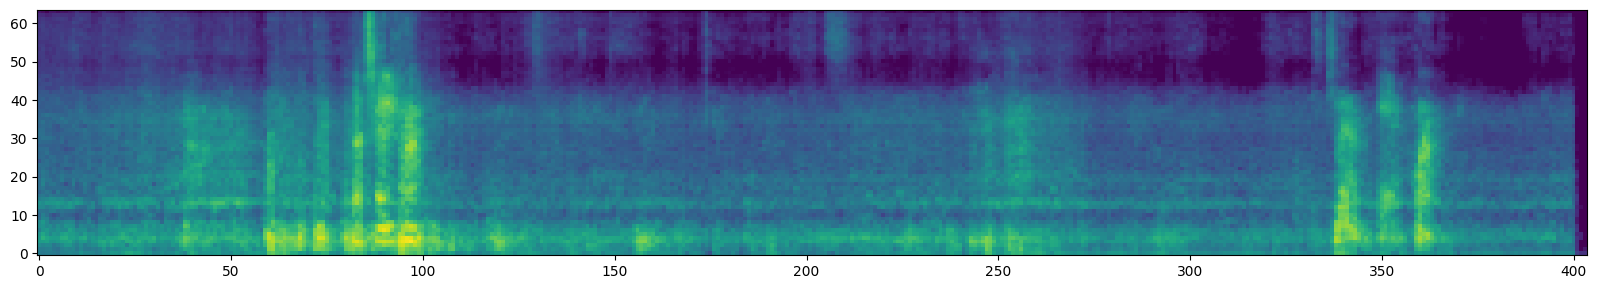

/u/li19/diffusers_with_dataloader/notebooks/imgs/spectrogram_sound of a dog barking, and a dog howling, while there is a person talking.png

In [388]:
# Set the figure size
fig= plt.figure(figsize=(20, 10))
# Show the image
plt.imshow(log_mel_spectrogram_db[0], origin='lower')
filename = f'imgs/spectrogram_{prompts[idx]}.png'
plt.savefig(filename)
plt.show()
display(FileLink(filename))



In [17]:

def get_pipe(device):
    model_path = "/u/li19/data_folder/model_cache/audio_journey_128"
    ckpt_path = "/u/li19/data_folder/testing/audio_journey_128_channel_norm/checkpoint-34000/unet"
    tokenizer = AutoTokenizer.from_pretrained("t5-large", model_max_length=512)
    text_encoder = T5EncoderModel.from_pretrained("t5-large")
    noise_scheduler = PNDMScheduler.from_pretrained("/u/li19/data_folder/model_cache/audio_journey_128", subfolder="scheduler")
    new_unet = UNet2DConditionModel.from_pretrained(ckpt_path)
    print(f'{device}: components loaded')
    
    pipe = StableDiffusionPipeline.from_pretrained(
        model_path,
        device_map=None, 
        safety_checker=None,
        low_cpu_mem_usage=False)
    
    print(f'{device}: pipe loaded')
    pipe.vae_scale_factor = 1
    pipe.to(device)
    pipe.unet = new_unet.to(device)
    pipe.scheduler = noise_scheduler
    pipe.tokenizer = tokenizer
    pipe.text_encoder = text_encoder.to(device)
    
    return pipe

In [18]:
tst_pipe = get_pipe(0)

Some weights of the model checkpoint at t5-large were not used when initializing T5EncoderModel: ['decoder.block.22.layer.1.EncDecAttention.o.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.10.layer.0.SelfAttention.k.weight', 'decoder.block.17.layer.2.DenseReluDense.wo.weight', 'decoder.block.10.layer.2.DenseReluDense.wi.weight', 'decoder.block.13.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.18.layer.0.SelfAttention.q.weight', 'decoder.block.21.layer.0.SelfAttention.o.weight', 'decoder.block.8.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.2.layer_norm.weight', 'decoder.block.8.layer.1.EncDecAttention.k.weight', 'decoder.block.17.layer.0.layer_norm.weight', 'decoder.block.11.layer.2.DenseReluDense.wi.weight', 'decoder.block.1.layer.0.SelfAttention.q.weight', 'decoder.block.18.layer.0.SelfAttention.k.weight', 'decoder.block.19.layer.0.SelfAttention.k

0: components loaded
0: pipe loaded
